In [0]:
!nvidia-smi
%cd /content/drive/My Drive/comp4211Proj/omniglot/python
!ls

Sat May  2 05:12:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from os import walk
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random

In [0]:
root_dir = './images_background/'
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

In [0]:
class OmniglotDataset(Dataset):
    def __init__(self, categories, root_dir, setSize, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.transform = transform
        self.setSize = setSize
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label = None
        if idx % 2 == 0: # select the same character for both images
            category = random.choice(categories)
            character = random.choice(category[1])
            imgDir = root_dir + category[0] + '/' + character
            img1Name = random.choice(os.listdir(imgDir))
            img2Name = random.choice(os.listdir(imgDir))
            img1 = Image.open(imgDir + '/' + img1Name)
            img2 = Image.open(imgDir + '/' + img2Name)
            # print(imgDir+'/'+img1Name)
            # print(imgDir+'/'+img2Name)
            label = 1.0
        else: # select a different character for both images
            category1, category2 = random.choice(categories), random.choice(categories)
            category1, category2 = random.choice(categories), random.choice(categories)
            character1, character2 = random.choice(category1[1]), random.choice(category2[1])
            imgDir1, imgDir2 = root_dir + category1[0] + '/' + character1, root_dir + category2[0] + '/' + character2
            img1Name = random.choice(os.listdir(imgDir1))
            img2Name = random.choice(os.listdir(imgDir2))
            while img1Name == img2Name:
                img2Name = random.choice(os.listdir(imgDir2))
            label = 0.0
            img1 = Image.open(imgDir1 + '/' + img1Name)
            img2 = Image.open(imgDir2 + '/' + img2Name)
#         plt.imshow(img1)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))          


In [0]:
dataSize = 10000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

transformations = transforms.Compose(
    [transforms.ToTensor()]) 

omniglotDataset = OmniglotDataset(categories, root_dir, dataSize, transformations)
train_set, val_set = random_split(omniglotDataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=16)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=16)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


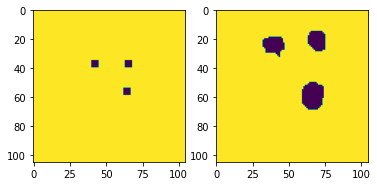

In [145]:
count0 = 0
count1 = 0
for img1, img2, label in train_loader:

    if label[0] == 1.0:
        print(img1[0])
        plt.subplot(1,2,1)
        plt.imshow(img1[0][0])
        plt.subplot(1,2,2)
        plt.imshow(img2[0][0])
        # print(label)
        break
    # break

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
    
    def convs(self, x):

        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.conv1(x))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.conv2(x))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.conv3(x))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.conv4(x))
        # 256, 6, 6
        return x
    
    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))
        x2 = self.convs(x2)
        x2 = x2.view(-1, 256 * 6 * 6)
        # x.view(x.size()[0], -1)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseBaseLine = Net()
siameseBaseLine = siameseBaseLine.to(device)

In [0]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [0]:
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

In [139]:
import torch.optim as optim

optimizer = optim.Adam(siameseBaseLine.parameters(), lr = 0.00006)
num_epochs = 10
criterion = nn.BCEWithLogitsLoss()
eval_every = 1000
save_path = 'siameseNet.pt'
train_losses, val_losses = train(siameseBaseLine, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/10],Train Loss: 0.3545, Valid Loss: 0.34566831
Model saved to ==> siameseNet.pt
Starting epoch 2
Epoch [2/10],Train Loss: 0.3390, Valid Loss: 0.32135715
Model saved to ==> siameseNet.pt
Starting epoch 3
Epoch [3/10],Train Loss: 0.3265, Valid Loss: 0.33809038
Starting epoch 4
Epoch [4/10],Train Loss: 0.3292, Valid Loss: 0.30292510
Model saved to ==> siameseNet.pt
Starting epoch 5
Epoch [5/10],Train Loss: 0.3119, Valid Loss: 0.29639455
Model saved to ==> siameseNet.pt
Starting epoch 6
Epoch [6/10],Train Loss: 0.3119, Valid Loss: 0.30203306
Starting epoch 7
Epoch [7/10],Train Loss: 0.2909, Valid Loss: 0.30172910
Starting epoch 8
Epoch [8/10],Train Loss: 0.2820, Valid Loss: 0.28587947
Model saved to ==> siameseNet.pt
Starting epoch 9
Epoch [9/10],Train Loss: 0.2768, Valid Loss: 0.27505071
Model saved to ==> siameseNet.pt
Starting epoch 10
Epoch [10/10],Train Loss: 0.2661, Valid Loss: 0.27573120
Finished Training


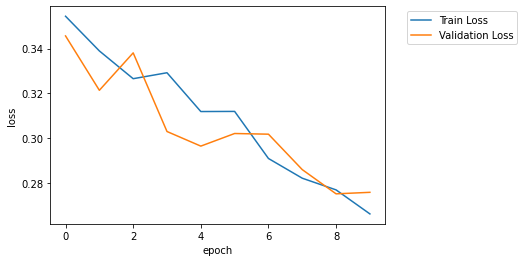

In [144]:


plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
